## Predict 3D structure of proteins

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
#import emachine as EM
import expectation_reflection as ER
from direct_info import direct_info

from data_processing import data_processing
import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
data_path = '../../protein/Pfam-A.full'

### Contact map from PDB structure

We select a specific protein to consider.

In [4]:
pfam_id = 'PF00186'

Read protein structures from protein data bank (PDB).

In [5]:
# read data
pdb = np.load('%s/%s/pdb_refs.npy'%(data_path,pfam_id))

# delete 'b' in front of letters (python 2 --> python 3)
pdb = np.array([pdb[t,i].decode('UTF-8') for t in range(pdb.shape[0]) \
         for i in range(pdb.shape[1])]).reshape(pdb.shape[0],pdb.shape[1])

npdb = pdb.shape[0]
print('number of pdb structures:',npdb)

number of pdb structures: 372


In [6]:
df = pd.DataFrame(pdb,columns = ['PF','seq','id','uniprot_start','uniprot_start',\
                                 'pdb_id','chain','pdb_start','pdb_end'])
df.head()

,PF,seq,id,uniprot_start,uniprot_start,pdb_id,chain,pdb_start,pdb_end
0,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,B,1,160
1,PF00186,69,Q5KZ26_GEOKA,1,160,1ZDR,A,1,160
2,PF00186,83,Q81R22_BACAN,2,160,3JWK,B,2,160
3,PF00186,83,Q81R22_BACAN,2,160,3S9U,B,2,160
4,PF00186,83,Q81R22_BACAN,2,160,3FL9,H,2,160


We select a PDB structure by (choising a specific value for `ipdb`) and calculate the contact map of this PDB structure.

In [7]:
def contact_map(pdb,ipdb,cols_removed):
    pdb_id = pdb[ipdb,5]
    pdb_chain = pdb[ipdb,6]
    pdb_start,pdb_end = int(pdb[ipdb,7]),int(pdb[ipdb,8])
    #print('pdb id, chain, start, end, length:',pdb_id,pdb_chain,pdb_start,pdb_end,pdb_end-pdb_start+1)

    #print('download pdb file')
    pdb_file = pdb_list.retrieve_pdb_file(pdb_id,file_format='pdb')
    #pdb_file = pdb_list.retrieve_pdb_file(pdb_id)
    chain = pdb_parser.get_structure(pdb_id,pdb_file)[0][pdb_chain]
    coords_all = np.array([a.get_coord() for a in chain.get_atoms()])
    coords = coords_all[pdb_start-1:pdb_end]
    #print('original pdb:')
    #print(coords.shape)

    coords_remain = np.delete(coords,cols_removed,axis=0)
    #print(coords_remain.shape)

    ct = distance_matrix(coords_remain,coords_remain)

    return ct

In [8]:
ipdb = 0
print('seq:',int(pdb[ipdb,1]))

# data processing
s0,cols_removed = data_processing(data_path,pfam_id,ipdb,\
                gap_seqs=0.2,gap_cols=0.2,prob_low=0.004,conserved_cols=0.9)

ct = contact_map(pdb,ipdb,cols_removed)

seq: 69
Structure exists: '/home/tai/19.09.3000_Protein/19.10.0700_ER_protein/zd/pdb1zdr.ent' 


We plot the contact map.

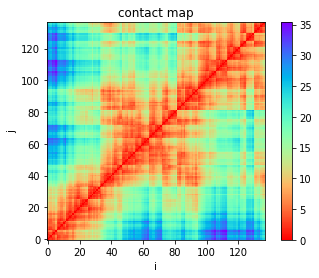

In [9]:
plt.title('contact map')
plt.imshow(ct,cmap='rainbow_r',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)

### Inferring the interactions between residues in protein sequences from multiple sequence alignment (MSA).

In [10]:
# number of positions
n_var = s0.shape[1]

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 

# number of variables
mx_sum = mx.sum()
my_sum = mx.sum() #!!!! my_sum = mx_sum

w = np.zeros((mx_sum,my_sum))
h0 = np.zeros(my_sum)

We convert the categorical sequence `s0` to one-hot sequences.

In [11]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
s = onehot_encoder.fit_transform(s0)

In [12]:
def predict_w(s,i0,i1i2,niter_max,l2):
    print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

In [13]:
res = Parallel(n_jobs = 32)(delayed(predict_w)\
        (s,i0,i1i2,niter_max=10,l2=0.1)\
        for i0 in range(n_var))

for i0 in range(n_var):
    i1,i2 = i1i2[i0,0],i1i2[i0,1]
       
    h01 = res[i0][0]
    w1 = res[i0][1]

    h0[i1:i2] = h01    
    w[:i1,i1:i2] = w1[:i1,:]
    w[i2:,i1:i2] = w1[i1:,:]

Make w2d to be symmetric.

In [14]:
w2d = w  # just for convenience
w2d = (w2d + w2d.T)/2.

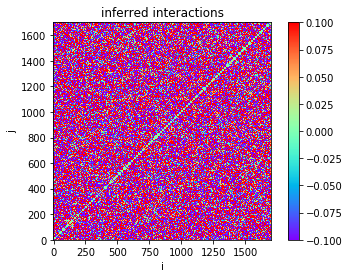

In [15]:
plt.title('inferred interactions')
plt.imshow(w2d,cmap='rainbow',origin='lower')
plt.clim(-0.1,0.1)
plt.xlabel('i')
plt.ylabel('j')
plt.colorbar(fraction=0.045, pad=0.05)

### Dirrect information measuring the interaction between positions

In [16]:
di = direct_info(s0,w2d)

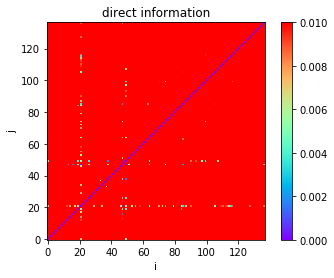

In [17]:
plt.title('direct information')
plt.imshow(di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.01)
plt.colorbar(fraction=0.045, pad=0.05)

### ROC curve

In [18]:
def roc_curve(ct,di,ct_thres):    
    ct1 = ct.copy()
    
    ct_pos = ct1 < ct_thres           
    ct1[ct_pos] = 1
    ct1[~ct_pos] = 0

    mask = np.triu(np.ones(di.shape[0],dtype=bool), k=1)
    order = di[mask].argsort()[::-1]

    ct_flat = ct1[mask][order]

    tp = np.cumsum(ct_flat, dtype=float)
    fp = np.cumsum(~ct_flat.astype(int), dtype=float)

    if tp[-1] != 0:
        tp /= tp[-1]
        fp /= fp[-1]
    
    return tp,fp

In [19]:
# find optimal threshold of distance
ct_thres = np.linspace(0.5,20.5,41,endpoint=True)
n = ct_thres.shape[0]

auc = np.zeros(n)
for i in range(n):
    tp,fp = roc_curve(ct,di,ct_thres[i])
    auc[i] = tp.sum()/tp.shape[0]  

#np.savetxt('auc.dat',(ct_thres,auc),fmt='%f')    

auc max: 1.5 0.8332288535852298


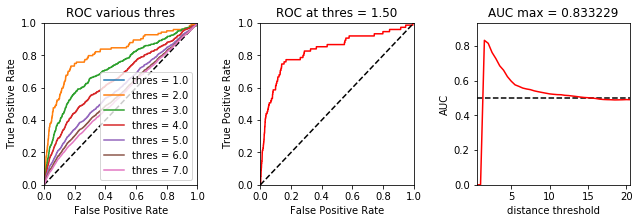

In [20]:
# plot at optimal threshold:
i0 = np.argmax(auc)    
print('auc max:',ct_thres[i0],auc[i0])
tp0,fp0 = roc_curve(ct,di,ct_thres[i0])

iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

plt.subplot2grid((1,3),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')
for i in iplot:
    tp,fp = roc_curve(ct,di,ct_thres[i])    
    plt.plot(fp,tp,label='thres = %s'%ct_thres[i])

plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot2grid((1,3),(0,1))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0]))
plt.plot(fp0,tp0,'r-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.subplot2grid((1,3),(0,2))
plt.title('AUC max = %f' %(auc[i0]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc,'r-')
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')

plt.tight_layout(h_pad=1, w_pad=1.5)
#plt.savefig('roc_curve.pdf', format='pdf', dpi=100)